In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
anime_path = r'C:\Users\mates\Desktop\anime.csv'
rating_path = r'C:\Users\mates\Desktop\rating.csv'

In [4]:
anime_df = pd.read_csv(anime_path)
rating_df = pd.read_csv(rating_path)

Visualizar as primeiras linhas do DF

In [5]:
print(anime_df.head())

   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  


In [6]:
print(rating_df.head())

   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1


Análise Descritiva das Colunas

In [7]:
print(anime_df.describe())
print(rating_df.describe())

           anime_id        rating       members
count  12294.000000  12064.000000  1.229400e+04
mean   14058.221653      6.473902  1.807134e+04
std    11455.294701      1.026746  5.482068e+04
min        1.000000      1.670000  5.000000e+00
25%     3484.250000      5.880000  2.250000e+02
50%    10260.500000      6.570000  1.550000e+03
75%    24794.500000      7.180000  9.437000e+03
max    34527.000000     10.000000  1.013917e+06
            user_id      anime_id        rating
count  7.813737e+06  7.813737e+06  7.813737e+06
mean   3.672796e+04  8.909072e+03  6.144030e+00
std    2.099795e+04  8.883950e+03  3.727800e+00
min    1.000000e+00  1.000000e+00 -1.000000e+00
25%    1.897400e+04  1.240000e+03  6.000000e+00
50%    3.679100e+04  6.213000e+03  7.000000e+00
75%    5.475700e+04  1.409300e+04  9.000000e+00
max    7.351600e+04  3.451900e+04  1.000000e+01


Verificar se há Valores Ausentes

In [8]:
print(anime_df.isnull().sum())
print('-')
print(rating_df.isnull().sum())

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
-
user_id     0
anime_id    0
rating      0
dtype: int64


Visualização gráfica

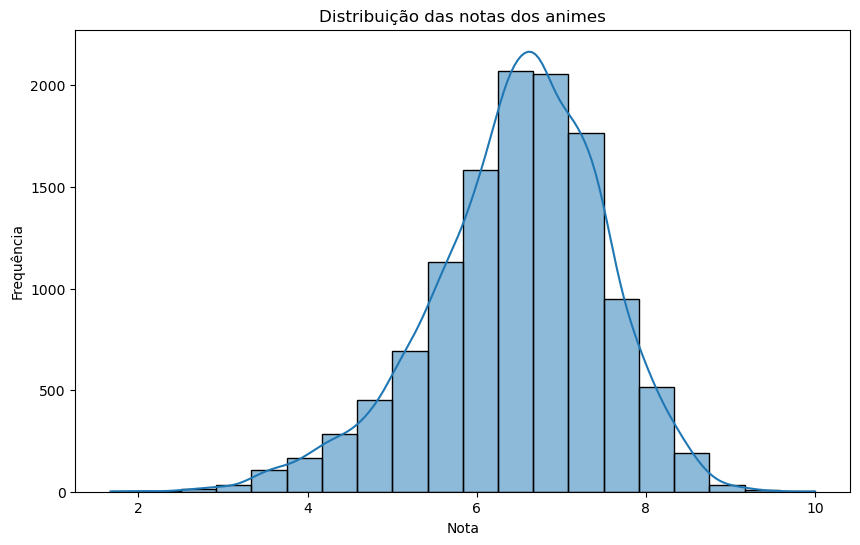

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(anime_df['rating'], bins=20, kde=True)
plt.title('Distribuição das notas dos animes')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.show()

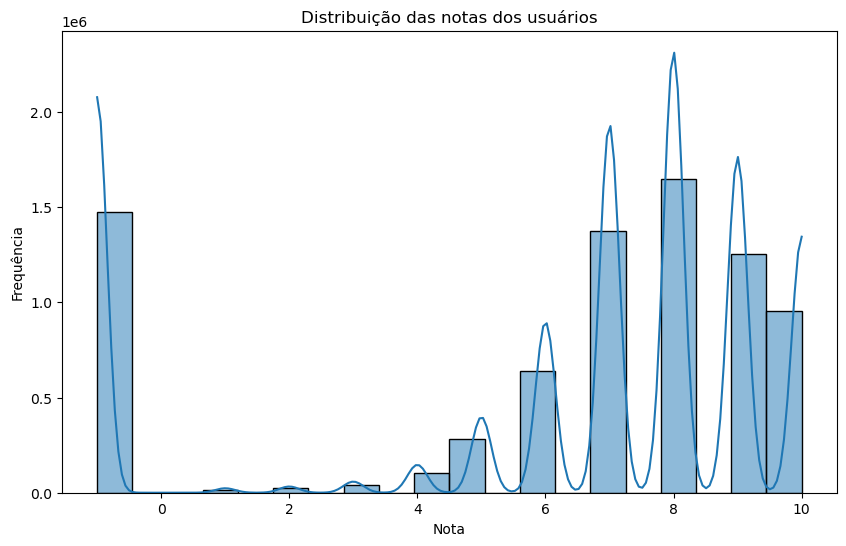

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(rating_df['rating'], bins=20, kde=True)
plt.title('Distribuição das notas dos usuários')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.show()

Remover linhas com notas negativas

In [11]:
rating_df = rating_df[rating_df['rating'] >= 0]

Verificar novamente valores ausentes

In [12]:
print(rating_df.isnull().sum())

user_id     0
anime_id    0
rating      0
dtype: int64


Resolver duplicatas calculando a média das notas para combinações duplicadas de user_id e anime_id

In [13]:
rating_df = rating_df.groupby(['user_id', 'anime_id'], as_index=False).mean()

Criar matriz de usuário-anime

In [14]:
user_anime_matrix = rating_df.pivot(index='user_id', columns='anime_id', values='rating').fillna(0)
print(user_anime_matrix.head())

anime_id  1      5      6      7      8      15     16     17     18     \
user_id                                                                   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    8.0    0.0    0.0    6.0    0.0    6.0    6.0   
7           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  19     ...  34238  34239  34240  34252  34283  34324  34325  34349  \
user_id          ...                                                           
1           0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2           0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0

Normalizar os dados

In [15]:
scaler = StandardScaler()
user_anime_matrix_scaled = scaler.fit_transform(user_anime_matrix)

Aplicar o SVD

In [16]:
svd = TruncatedSVD(n_components=20)
user_factors = svd.fit_transform(user_anime_matrix_scaled)
anime_factors = svd.components_.T

Realizar o Treinamento do Modelo Inicial

Reconstruir a matriz de ratings prevista

In [17]:
predicted_ratings = np.dot(user_factors, anime_factors.T)

Função para prever a nota de um usuário para um anime específico

In [18]:
def predict_rating(user_id, anime_id):
    user_index = user_anime_matrix.index.get_loc(user_id)
    anime_index = user_anime_matrix.columns.get_loc(anime_id)
    return predicted_ratings[user_index, anime_index]

Exemplo de previsão

In [19]:
print(predict_rating(1, 20))

-0.20630497383381927


Definir a forma de avaliação de desempenho do modelo

Função para calcular o RMSE

In [20]:
def calculate_rmse(true_ratings, predicted_ratings):
    return np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

Extraindo as notas reais e previstas

In [21]:
true_ratings = rating_df['rating'].values
predicted_ratings = [predict_rating(row['user_id'], row['anime_id']) for _, row in rating_df.iterrows()]

Avaliação do desempenho do modelo

In [22]:
rmse = calculate_rmse(true_ratings, predicted_ratings)
print(f'RMSE: {rmse}')

RMSE: 7.895129823213258


Ajustar o número de componentes no SVD

In [23]:
n_components = 50
svd = TruncatedSVD(n_components=n_components)

Normalização dos dados

In [24]:
scaler = StandardScaler()
user_anime_matrix_scaled = scaler.fit_transform(user_anime_matrix)

Aplicando SVD

In [25]:
user_factors = svd.fit_transform(user_anime_matrix_scaled)
anime_factors = svd.components_.T

Reconstruindo a matriz de ratings prevista

In [26]:
predicted_ratings = np.dot(user_factors, anime_factors.T)

Função para prever a nota de um usuário para um anime específico

In [27]:
def predict_rating(user_id, anime_id):
    try:
        user_index = user_anime_matrix.index.get_loc(user_id)
        anime_index = user_anime_matrix.columns.get_loc(anime_id)
        return predicted_ratings[user_index, anime_index]
    except KeyError:
        return np.nan  # Retorna NaN se o usuário ou anime não estiver na matriz

Avaliação do desempenho do modelo

In [28]:
true_ratings = rating_df['rating'].values
predicted_ratings_list = [
    predict_rating(row['user_id'], row['anime_id']) for _, row in rating_df.iterrows()
]
predicted_ratings_cleaned = [pred for pred in predicted_ratings_list if not np.isnan(pred)]
true_ratings_cleaned = [true for pred, true in zip(predicted_ratings_list, true_ratings) if not np.isnan(pred)]

rmse = calculate_rmse(true_ratings_cleaned, predicted_ratings_cleaned)
print(f'RMSE ajustado: {rmse}')

RMSE ajustado: 7.944567002477173


Classe personalizada para aplicar SVD

In [29]:
class SVDRecommender(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.svd = TruncatedSVD(n_components=self.n_components)

    def fit(self, X, y=None):
        self.svd.fit(X)
        self.user_factors = self.svd.transform(X)
        self.anime_factors = self.svd.components_.T
        return self

    def transform(self, X):
        return np.dot(self.user_factors, self.anime_factors.T)

    def predict(self, X):
        user_ids = X[:, 0].astype(int)
        anime_ids = X[:, 1].astype(int)
        predictions = np.array([self.user_factors[user_id].dot(self.anime_factors[anime_id]) 
                                for user_id, anime_id in zip(user_ids, anime_ids)])
        return predictions

Pipeline

In [30]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svd_recommender', SVDRecommender())
])

Grid Search

In [31]:
param_grid = {
    'svd_recommender__n_components': [10, 20, 30, 40, 50]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(user_anime_matrix.values, user_anime_matrix.values)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\mates\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mates\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\mates\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\mates\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\mates\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "c:\Users\mates\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 111, in _check_reg_targets
    rai

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svd_recommender', SVDRecommender())]),
             param_grid={'svd_recommender__n_components': [10, 20, 30, 40, 50]},
             scoring='neg_mean_squared_error', verbose=1)

Melhor número de componentes

In [32]:
best_n_components = grid_search.best_params_['svd_recommender__n_components']
print(f"Melhor número de componentes: {best_n_components}")

Melhor número de componentes: 10


Reavaliar com o melhor modelo

In [33]:
best_svd = TruncatedSVD(n_components=best_n_components)
user_factors = best_svd.fit_transform(user_anime_matrix_scaled)
anime_factors = best_svd.components_.T
predicted_ratings = np.dot(user_factors, anime_factors.T)

Função para prever a nota de um usuário para um anime específico

In [34]:
def predict_rating(user_id, anime_id):
    try:
        user_index = user_anime_matrix.index.get_loc(user_id)
        anime_index = user_anime_matrix.columns.get_loc(anime_id)
        return predicted_ratings[user_index, anime_index]
    except KeyError:
        return np.nan

Avaliação do desempenho do modelo

In [35]:
true_ratings = rating_df['rating'].values
predicted_ratings_list = [predict_rating(row['user_id'], row['anime_id']) for _, row in rating_df.iterrows()]
predicted_ratings_cleaned = [pred for pred in predicted_ratings_list if not np.isnan(pred)]
true_ratings_cleaned = [true for pred, true in zip(predicted_ratings_list, true_ratings) if not np.isnan(pred)]
rmse = np.sqrt(mean_squared_error(true_ratings_cleaned, predicted_ratings_cleaned))
print(f'RMSE ajustado após Grid Search: {rmse}')

RMSE ajustado após Grid Search: 7.88528435998298


Visualizações

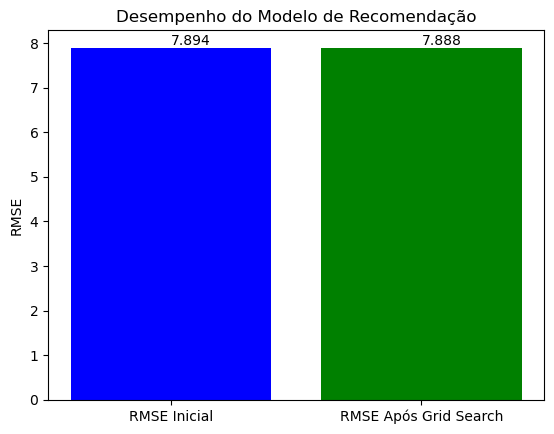

In [36]:
initial_rmse = 7.894
adjusted_rmse = 7.888

labels = ['RMSE Inicial', 'RMSE Após Grid Search']
values = [initial_rmse, adjusted_rmse]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['blue', 'green'])

ax.set_ylabel('RMSE')
ax.set_title('Desempenho do Modelo de Recomendação')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom')

plt.show()